# Response Profile of the Blowfly H1 Neuron
This document contains the preprocessing and analysis of electrophysiological recordings of the blowfly H1 neuron taken on October 18th, 2017. An impressive set of recordings were obtained from a single specimen over the course of several hours. A black-and-white visual gradient was presented to the left eye of a blowfly as extracellular activity was recorded from the right side of its brain. The metadata of the recordings are displayed below.

In [1]:
from pandas import read_csv
metadata = read_csv('metadata.csv')
metadata

,Recording,Filename,X,Y,Z,Stimulus,Motion,Direction,Speed,Notes
0,1,17o18000.abf,5980,16617,22590,Strip 1,Steps,CCW,3.5,Start of position 1. high noise
1,2,17o18001.abf,5980,16617,22590,Strip 1,Steps,CCW,3.5,Noise fixed with Alan's help
2,3,17o18002.abf,5980,16617,22590,Strip 1,Oscillate,CW,3.5,NaN
3,4,17o18003.abf,5980,16617,22590,Strip 1,Oscillate,CW,7.0,NaN
4,5,17o18004.abf,5998,16617,22520,Strip 1,Steps,CCW,3.5,Start of position 2
5,6,17o18005.abf,5998,16617,22520,Strip 1,Oscillate,CCW,3.5,NaN
6,7,17o18006.abf,5998,16617,22520,Strip 1,Oscillate,CCW,7.0,NaN
7,8,17o18007.abf,5998,16617,22520,Strip 1,Oscillate,CCW,3.5,Added additional saline to brain. observed muc...
8,9,17o18008.abf,5998,16617,22520,Strip 1,Steps,CCW,3.5,NaN
9,10,17o18009.abf,5998,16617,22520,Strip 1,Oscillate,CCW,7.0,NaN


## Step 1: Format Recording
In this first section, we reformat the raw recording into a fiff file, thereby making it compatible with the mne-python package. This will come in handy for preprocessing and analysis.

In [2]:
import neo
import numpy as np
from mne import create_info
from mne.io import RawArray

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main body.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for f in metadata.Filename:

    ## Load recordings.
    recordings, = neo.AxonIO(filename='raw/%s' %f).read_block().segments
    h1, drum = recordings.analogsignals

    ## Concatenate raw recordings.
    data = np.hstack([np.asarray(h1, dtype=np.float64)  * 1e-6, # uV --> V 
                      np.asarray(drum, dtype=np.float64)
                     ]).T

    ## Create info object.
    sfreq = float(h1.sampling_rate)
    ch_names = ['h1', 'drum']
    ch_types = ['bio', 'stim']

    info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

    ## Create Raw object.
    raw = RawArray(data, info)

    ## Save Raw object.
    raw.save('raw/%s' %f.replace('.abf', '_raw.fif'), overwrite=True, verbose=False)

print('Done.')

Creating RawArray with float64 data, n_channels=2, n_times=3416576
    Range : 0 ... 3416575 =      0.000 ...   341.658 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=1659904
    Range : 0 ... 1659903 =      0.000 ...   165.990 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=1842176
    Range : 0 ... 1842175 =      0.000 ...   184.218 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=1215488
    Range : 0 ... 1215487 =      0.000 ...   121.549 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=1785344
    Range : 0 ... 1785343 =      0.000 ...   178.534 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=2120704
    Range : 0 ... 2120703 =      0.000 ...   212.070 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=1588224
    Range : 0 ... 1588223 =      0.000 ...   158.822 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=1192960
    Range

## Step 2: Preprocess Recordings

### Step 2a: Event Detection of Step-Motion Recordings
Demonstrating useful code for identifying event markers in the stepwise-motion recordings.

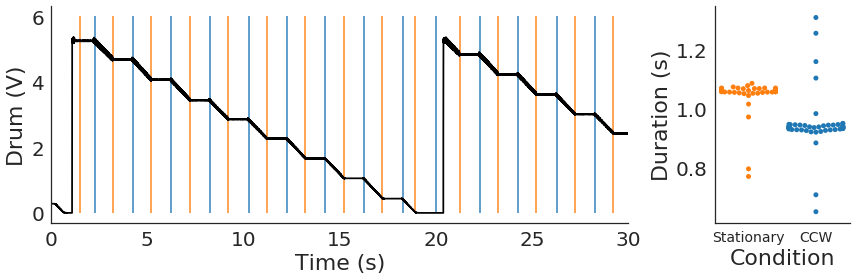

In [3]:
import numpy as np
from mne.io import Raw
import matplotlib.pyplot as plt
import seaborn as sns
from mne.io import Raw
from utilities import *
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
f = 'raw/17o18014_raw.fif' # representative stepwise-motion recording.
direction = 'CCW'

## Event detection paramters.
h_freq = 5.0       # lowpass, Hz
min_duration = 0.5 # seconds
tol = 5e-5         # voltage

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main body.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
raw = Raw(f, preload=True, verbose=False)
sfreq = raw.info['sfreq']

## Extract stim (drum) data.
_, arr = raw.get_data()

## Identify events.
events = find_step_events(arr, direction, sfreq, h_freq, min_duration, tol)

## Compute epoch lengths.
lengths = np.diff(events[:,:-1], axis=1) / sfreq

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(12,4))

## Plot drum timeseries.
ax = plt.subplot2grid((1,4),(0,0),colspan=3)
ax.plot(raw.times, arr, color='k')

## Add event markers.
for n, color in zip(np.unique(events[:,-1]), ['#ff7f0e', '#1f77b4']):
    ax.vlines(raw.times[events[events[:,-1]==n, 0]], 0, 6, color=color, alpha=0.8)    

## Add info.
ax.set(xlim=(0,30), xlabel='Time (s)', ylabel='Drum (V)')
    
## Plot drum timeseries.
ax = plt.subplot2grid((1,4),(0,3))
sns.swarmplot(data=[lengths[events[:,-1]==n].squeeze() for n in np.unique(events[:,-1])], 
              palette=['#ff7f0e', '#1f77b4'], ax=ax)
ax.set(xlabel='Condition', ylabel='Duration (s)')
ax.set_xticklabels(['Stationary',direction], fontsize=14)

sns.despine()
plt.tight_layout()

### Step 2b: Event Detection of Oscillation Motion Recordings
Demonstrating useful code for identifying event markers in the oscillatory-motion recordings.

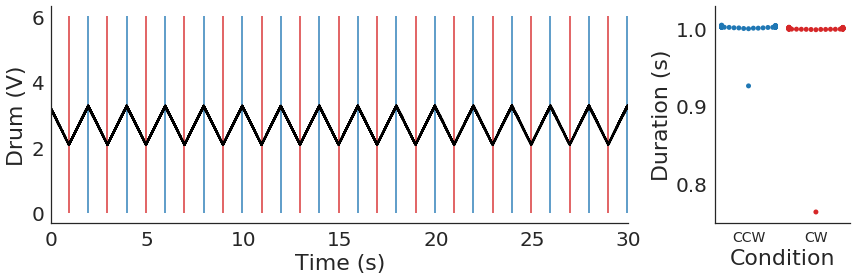

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
f = 'raw/17o18015_raw.fif' # representative oscillation recording.
direction = 'CCW'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main body.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
raw = Raw(f, preload=True, verbose=False)
sfreq = raw.info['sfreq']

## Extract stim (drum) data.
_, arr = raw.get_data()

## Identify events.
events = find_oscillation_events(arr, direction, sfreq, h_freq)

## Compute epoch lengths.
lengths = np.diff(events[:,:-1], axis=1) / sfreq

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(12,4))

## Plot drum timeseries.
ax = plt.subplot2grid((1,4),(0,0),colspan=3)
ax.plot(raw.times, arr, color='k')

## Add event markers.
for n, color in zip(np.unique(events[:,-1]), ['#1f77b4','#d62728']):
    ax.vlines(raw.times[events[events[:,-1]==n, 0]], 0, 6, color=color, alpha=0.8)    

## Add info.
ax.set(xlim=(0,30), xlabel='Time (s)', ylabel='Drum (V)')
    
## Plot drum timeseries.
ax = plt.subplot2grid((1,4),(0,3))
sns.swarmplot(data=[lengths[events[:,-1]==n].squeeze() for n in np.unique(events[:,-1])], 
              palette=['#1f77b4','#d62728'], ax=ax)
ax.set(xlabel='Condition', ylabel='Duration (s)')
ax.set_xticklabels(['CCW','CW'], fontsize=14)

sns.despine()
plt.tight_layout()